In [2]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


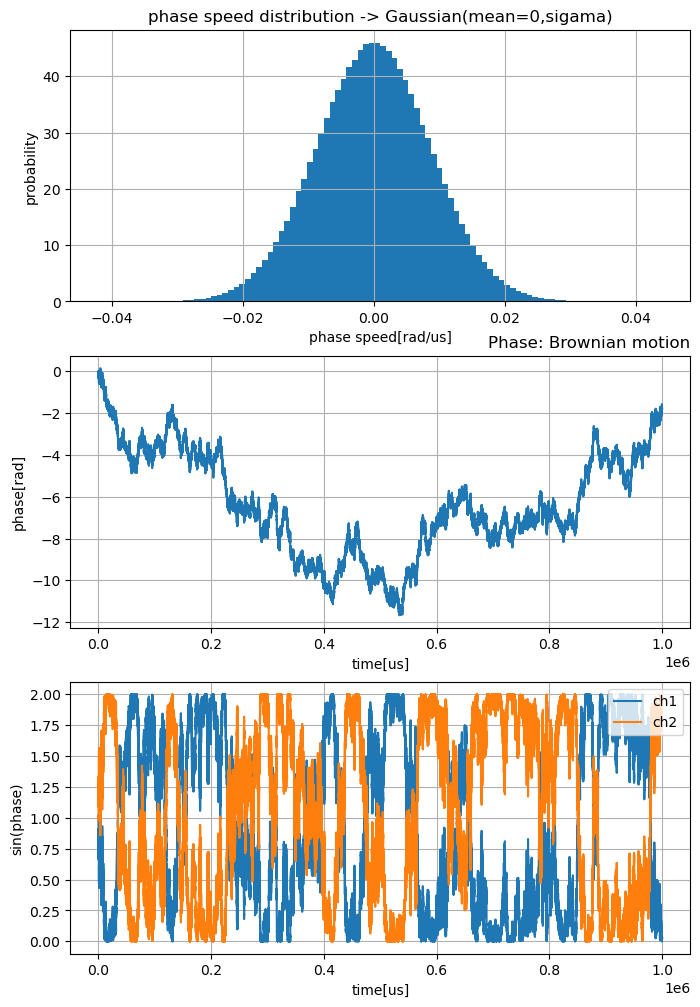

In [25]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi # deg/us -> rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [5]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())

def fb_weight(measure, time_exposure, sigma=3):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered

    
def simu_phase(phase_speed,time_exposure,method):
    """
    method 1: instant feedback  
    method 2: average feedback  
    method 3: average feedback with iteration  
    method 4: weighted feedback  
    """
    
    time_iter1=2 # method 3 迭代参数，每隔time_iter1个exposure再进行一次测量
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M=np.zeros_like(phase_speed_M)
    phase_measure_M=np.zeros(phase_speed_M.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M[i]=np.cumsum(phase_speed_M[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M[i],2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M[i]=get_phase_from_count(ch1_measure,ch2_measure)
        
        
        if i<(sig_ch1_exposure.shape[0]-1):
            if method==1:
                phase_speed_M[i+1,0]-=phase_measure_M[i] # 反馈到下一个exposure的起始点
            if method==2 or method==3:
                c0=phase_measure_M[i]
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1]-=phase_fb_M/time_exposure # 均匀反馈到下一个exposure时间
            if method==4:
                c0=fb_weight(phase_measure_M[i],time_exposure*(1.2/3)*(1.2/3))
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1,0]-=phase_fb_M # 均匀反馈到下一个exposure时间

        if method==3:
            if i%time_iter1==0 and i!=0:
                ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i].sum())
                ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i].sum())
                phase_measure_M_it1=get_phase_from_count(ch1_measure,ch2_measure)
                c0=get_phase_from_count(ch1_measure,ch2_measure)#/100
                phase_fb_M=np.sign(phase_measure_M_it1)*np.abs(c0)
                phase_speed_M[i:i+time_iter1]-=phase_fb_M/time_exposure/time_iter1
        
        if method==5:
                ##-- 反馈
            if i<(sig_ch1_exposure.shape[0]-1):
                c0=fb_weight(phase_measure_M[i],time_exposure=time_exposure,sigma=1.2)
                phase_speed_M[i+1,0]-=c0#/time_exposure # 反馈到下一个exposure
            
                ##-- 迭代反馈 one 10*time_exposure
                if i%time_iter1==0 and i!=0:
                    phaseit1=phase_M[i,-1]+phase_speed_M[i+1,0]
                    suffix1=get_sig_from_phase(phaseit1,1)
                    suffix2=get_sig_from_phase(phaseit1,2)
                    ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
                    ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
                    phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
                    phase_measure_it1_M5[i]=phase_measure_M5_it1
                    c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure,sigma=1.2)
                    phase_speed_M[i+1,1]-=c0

        phase_offest=phase_M[i,-1]
    phase_out_M=np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M


In [80]:
np.std(simu_phase(phase_speed,time_exposure=10,method=5))

100%|██████████| 100000/100000 [00:03<00:00, 26031.92it/s]


0.0802756212662077

In [81]:
df=pd.DataFrame(columns=['time_exposure','phase_var_M1','phase_var_M4','phase_var_M5'])
time_test=[2,5,10,20,40,50,80,100,200,250,400,500,800]
time_d=[]
phase_var_M1=[]
phase_var_M4=[]
phase_var_M5=[]
for time_exposure in time_test:
    time_d.append(time_exposure)
    #phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=1)
    #phase_var_M1.append(np.var(phase_out))
    phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=4)
    phase_var_M4.append(np.var(phase_out))
    phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=5)
    phase_var_M5.append(np.var(phase_out))
df['time_exposure']=time_d
#df['phase_var_M1']=phase_var_M1
df['phase_var_M4']=phase_var_M4
df['phase_var_M5']=phase_var_M5

df

100%|██████████| 1250/1250 [00:00<00:00, 20500.50it/s]


,time_exposure,phase_var_M1,phase_var_M4,phase_var_M5
0,2,NaN,0.007239,0.005000
1,5,NaN,0.007612,0.005732
2,10,NaN,0.008224,0.006444
3,20,NaN,0.008706,0.007378
4,40,NaN,0.009270,0.008811
5,50,NaN,0.009664,0.009318
6,80,NaN,0.010922,0.011061
7,100,NaN,0.011543,0.012275
8,200,NaN,0.017937,0.018840
9,250,NaN,0.020654,0.021760


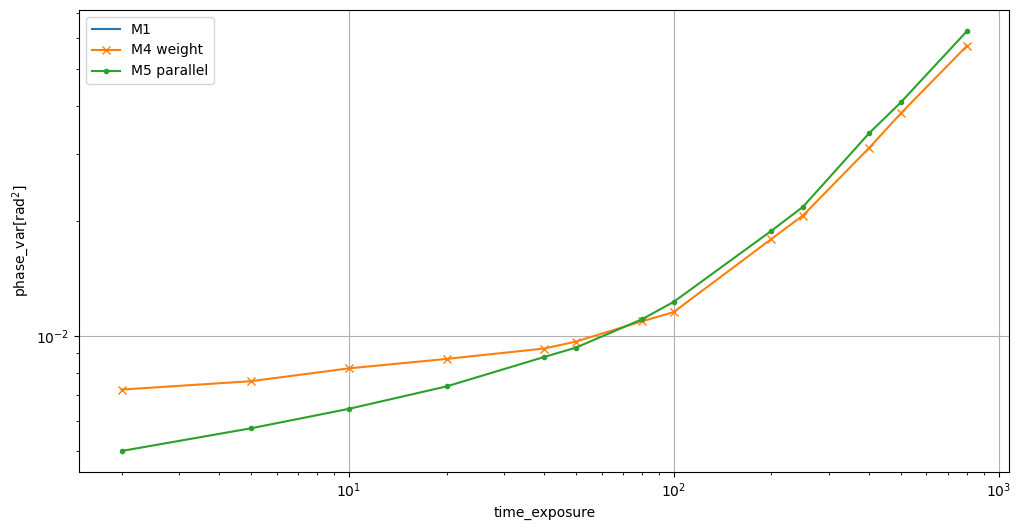

In [83]:
plt.figure(figsize=(12,6))
plt.plot(df['time_exposure'],df['phase_var_M1'],label='M1')
plt.plot(df['time_exposure'],df['phase_var_M4'],'x-',label='M4 weight')
plt.plot(df['time_exposure'],df['phase_var_M5'],'.-',label='M5 parallel')
plt.legend() 
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time_exposure')
plt.ylabel('phase_var[rad$^2$]')
plt.show()

## 根据反馈方向的准确性确定合适的time exposure

In [4]:
def simu_phase_M4(time_exposure,sigma=3):
    param=(sigma/3)**2
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M4=np.zeros_like(phase_speed_M4)
    phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量出的反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
        #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
        c0=phase_measure_M4[i]
        phase_fb_M4=fb_weight(c0,time_exposure=time_exposure*param)
        
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M4[i+1,0]-=phase_fb_M4#/time_exposure # 反馈到下一个exposure

        phase_offest=phase_M4[i,-1]
    phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
    return phase_out_M4,phase_measure_M4

In [5]:
df=pd.DataFrame(columns=['time_exposure'])
time_test=[2,5,10,20,40,50,80,100,200,250,400,500,800]
time_d=[]
phase_var_M4=[]
phase_fb_dirc_M4_error=[]
phase_fb_dirc_M4_good=[]
for time_exposure in time_test:
    time_d.append(time_exposure)
    phase_out,phase_measure=simu_phase_M4(time_exposure=time_exposure,sigma=1.2)
    phase_var_M4.append(np.var(phase_out))
    fb_dirc=np.sign(phase_measure*(phase_out.reshape((-1,time_exposure))[:,-1]))
    err=fb_dirc[fb_dirc<0].size/fb_dirc.size
    good=fb_dirc[fb_dirc>0].size/fb_dirc.size
    phase_fb_dirc_M4_error.append(err)
    phase_fb_dirc_M4_good.append(good)
df['time_exposure']=time_d
#df['phase_var_M1']=phase_var_M1
df['phase_var_M4']=phase_var_M4
df['feedback error']=phase_fb_dirc_M4_error
df['feedback good']=phase_fb_dirc_M4_good

df



  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [00:00<00:00, 4631.47it/s]


,time_exposure,phase_var_M4,feedback error,feedback good
0,2,0.007239,0.345796,0.449904
1,5,0.007612,0.353835,0.522080
2,10,0.008224,0.337110,0.579030
3,20,0.008706,0.309480,0.635340
4,40,0.009270,0.272160,0.695800
5,50,0.009664,0.260300,0.709500
6,80,0.010922,0.229280,0.748480
7,100,0.011543,0.218000,0.765200
8,200,0.017937,0.201400,0.791400
9,250,0.020654,0.175750,0.817000


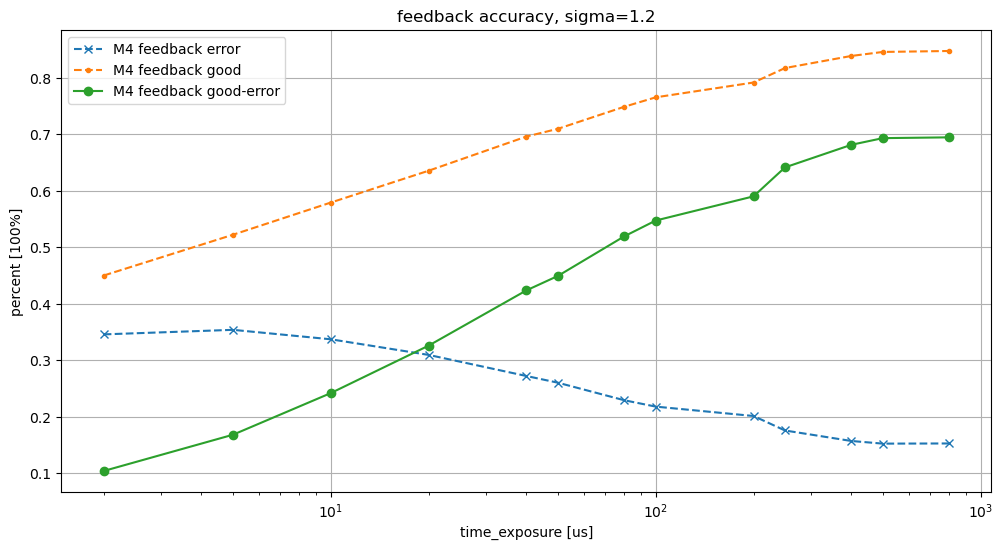

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df['time_exposure'],df['feedback error'],'x--',label='M4 feedback error')
plt.plot(df['time_exposure'],df['feedback good'],'.--',label='M4 feedback good')
plt.plot(df['time_exposure'],df['feedback good']-df['feedback error'],'o-',label='M4 feedback good-error')
plt.title('feedback accuracy, sigma=1.2')
plt.legend()
plt.grid()
plt.xscale('log')
plt.xlabel('time_exposure [us]')
plt.ylabel('percent [100%]')
plt.show()

如果以60%的反馈准确度作为标准，那么time exposure应该选择在10us左右

### 不同sigma的补偿效果

In [36]:
df_sigma=pd.DataFrame(columns=['sigma'])
sigma_test=np.arange(0.1,3.1,0.1)
time_exposure=10 #us
time_d=[]
phase_M4_sigma=[]
phase_var_M4=[]
phase_fb_dirc_M4_error=[]
phase_fb_dirc_M4_good=[]
for sigma in sigma_test:
    time_d.append(time_exposure)
    phase_M4_sigma.append(sigma)
    phase_out,phase_measure=simu_phase_M4(time_exposure=time_exposure,sigma=sigma)
    phase_var_M4.append(np.var(phase_out))
    fb_dirc=np.sign(phase_measure*(phase_out.reshape((-1,time_exposure))[:,-1]))
    err=fb_dirc[fb_dirc<0].size/fb_dirc.size
    good=fb_dirc[fb_dirc>0].size/fb_dirc.size
    phase_fb_dirc_M4_error.append(err)
    phase_fb_dirc_M4_good.append(good)
df_sigma['time_exposure']=time_d
df_sigma['sigam']=phase_M4_sigma
df_sigma['phase_var_M4']=phase_var_M4
df_sigma['feedback error']=phase_fb_dirc_M4_error
df_sigma['feedback good']=phase_fb_dirc_M4_good

100%|██████████| 100000/100000 [00:02<00:00, 36418.13it/s]


ValueError: Length of values (30) does not match length of index (13)

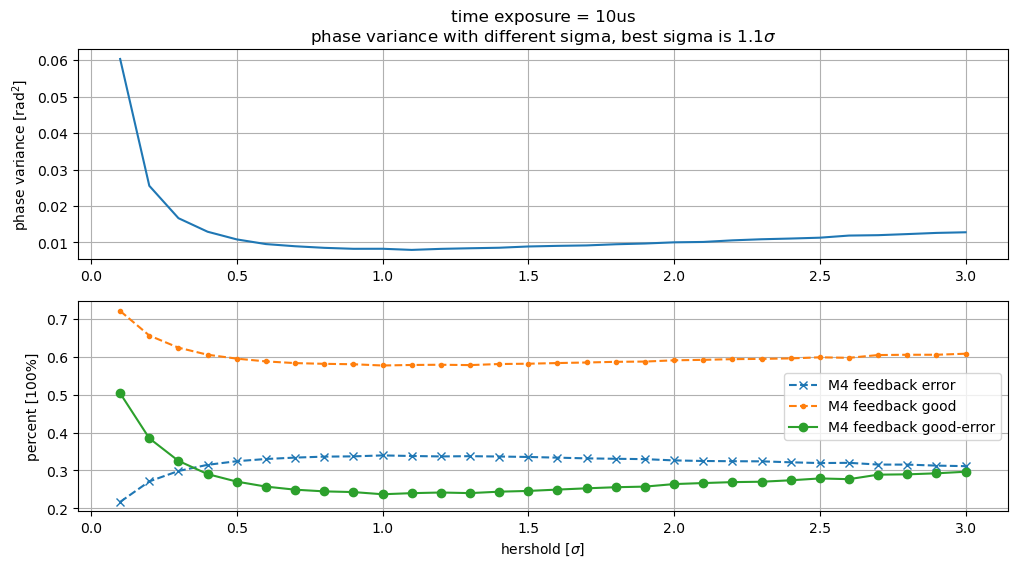

In [59]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(df_sigma['sigma'],df_sigma['phase_var_M4'])
plt.ylabel('phase variance [rad$^2$]')
plt.title('time exposure = {}us\n'.format(time_exposure)+'phase variance with different sigma, best sigma is {}$\\sigma$'.format(df_sigma['sigma'][df_sigma['phase_var_M4'].idxmin()]))
plt.grid()
plt.subplot(212)
plt.plot(df_sigma['sigma'],df_sigma['feedback error'],'x--',label='M4 feedback error')
plt.plot(df_sigma['sigma'],df_sigma['feedback good'],'.--',label='M4 feedback good')
plt.plot(df_sigma['sigma'],df_sigma['feedback good']-df_sigma['feedback error'],'o-',label='M4 feedback good-error')
plt.legend()
plt.grid()
plt.xlabel('hershold [$ \\sigma $]')
plt.ylabel('percent [100%]')
plt.show()


100%|██████████| 500000/500000 [00:17<00:00, 29147.73it/s]


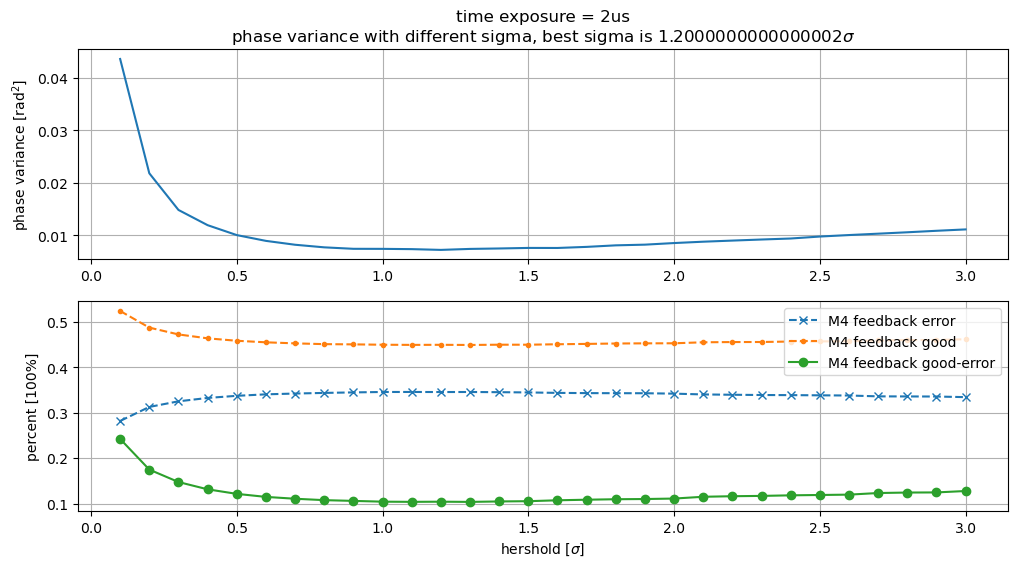

In [67]:
df_sigma=pd.DataFrame(columns=['sigma'])
sigma_test=np.arange(0.1,3.1,0.1)
time_exposure=2 #us
time_d=[]
phase_M4_sigma=[]
phase_var_M4=[]
phase_fb_dirc_M4_error=[]
phase_fb_dirc_M4_good=[]
for sigma in sigma_test:
    time_d.append(time_exposure)
    phase_M4_sigma.append(sigma)
    phase_out,phase_measure=simu_phase_M4(time_exposure=time_exposure,sigma=sigma)
    phase_var_M4.append(np.var(phase_out))
    fb_dirc=np.sign(phase_measure*(phase_out.reshape((-1,time_exposure))[:,-1]))
    err=fb_dirc[fb_dirc<0].size/fb_dirc.size
    good=fb_dirc[fb_dirc>0].size/fb_dirc.size
    phase_fb_dirc_M4_error.append(err)
    phase_fb_dirc_M4_good.append(good)
df_sigma['time_exposure']=time_d
df_sigma['sigma']=phase_M4_sigma
df_sigma['phase_var_M4']=phase_var_M4
df_sigma['feedback error']=phase_fb_dirc_M4_error
df_sigma['feedback good']=phase_fb_dirc_M4_good

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(df_sigma['sigma'],df_sigma['phase_var_M4'])
plt.ylabel('phase variance [rad$^2$]')
plt.title('time exposure = {}us\n'.format(time_exposure)+'phase variance with different sigma, best sigma is {}$\\sigma$'.format(df_sigma['sigma'][df_sigma['phase_var_M4'].idxmin()]))
plt.grid()
plt.subplot(212)
plt.plot(df_sigma['sigma'],df_sigma['feedback error'],'x--',label='M4 feedback error')
plt.plot(df_sigma['sigma'],df_sigma['feedback good'],'.--',label='M4 feedback good')
plt.plot(df_sigma['sigma'],df_sigma['feedback good']-df_sigma['feedback error'],'o-',label='M4 feedback good-error')
plt.legend()
plt.grid()
plt.xlabel('hershold [$ \\sigma $]')
plt.ylabel('percent [100%]')
plt.show()

100%|██████████| 200000/200000 [00:06<00:00, 30400.07it/s]


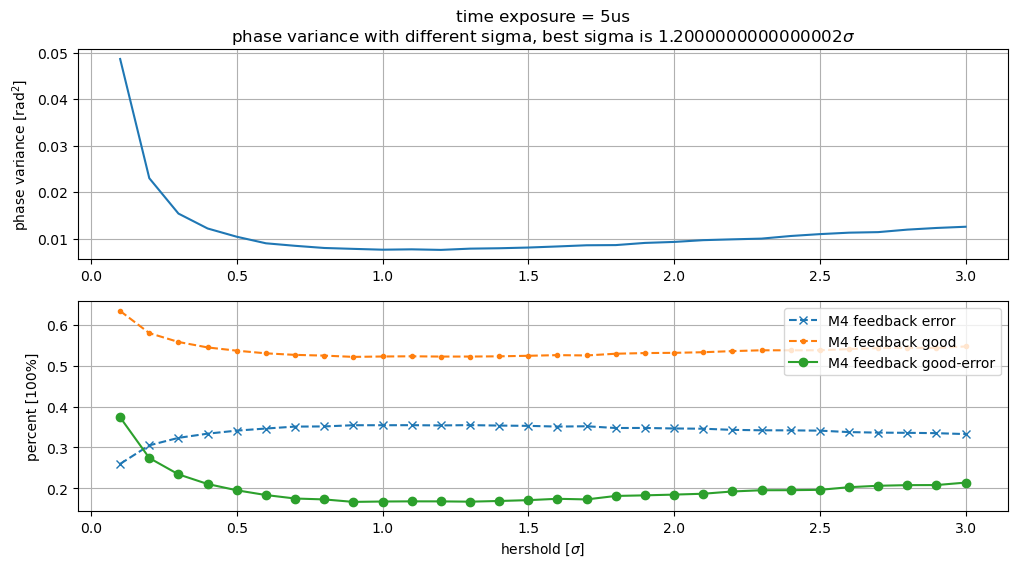

In [68]:
df_sigma=pd.DataFrame(columns=['sigma'])
sigma_test=np.arange(0.1,3.1,0.1)
time_exposure=5 #us
time_d=[]
phase_M4_sigma=[]
phase_var_M4=[]
phase_fb_dirc_M4_error=[]
phase_fb_dirc_M4_good=[]
for sigma in sigma_test:
    time_d.append(time_exposure)
    phase_M4_sigma.append(sigma)
    phase_out,phase_measure=simu_phase_M4(time_exposure=time_exposure,sigma=sigma)
    phase_var_M4.append(np.var(phase_out))
    fb_dirc=np.sign(phase_measure*(phase_out.reshape((-1,time_exposure))[:,-1]))
    err=fb_dirc[fb_dirc<0].size/fb_dirc.size
    good=fb_dirc[fb_dirc>0].size/fb_dirc.size
    phase_fb_dirc_M4_error.append(err)
    phase_fb_dirc_M4_good.append(good)
df_sigma['time_exposure']=time_d
df_sigma['sigma']=phase_M4_sigma
df_sigma['phase_var_M4']=phase_var_M4
df_sigma['feedback error']=phase_fb_dirc_M4_error
df_sigma['feedback good']=phase_fb_dirc_M4_good

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(df_sigma['sigma'],df_sigma['phase_var_M4'])
plt.ylabel('phase variance [rad$^2$]')
plt.title('time exposure = {}us\n'.format(time_exposure)+'phase variance with different sigma, best sigma is {}$\\sigma$'.format(df_sigma['sigma'][df_sigma['phase_var_M4'].idxmin()]))
plt.grid()
plt.subplot(212)
plt.plot(df_sigma['sigma'],df_sigma['feedback error'],'x--',label='M4 feedback error')
plt.plot(df_sigma['sigma'],df_sigma['feedback good'],'.--',label='M4 feedback good')
plt.plot(df_sigma['sigma'],df_sigma['feedback good']-df_sigma['feedback error'],'o-',label='M4 feedback good-error')
plt.legend()
plt.grid()
plt.xlabel('hershold [$ \\sigma $]')
plt.ylabel('percent [100%]')
plt.show()

### 根据补偿时间与残差的关系去选择合适的并行时间

In [30]:
np.std(simu_phase(phase_speed=phase_speed,time_exposure=2,method=4))

100%|██████████| 500000/500000 [01:42<00:00, 4900.10it/s] 


0.08508131056717523

In [26]:
np.std(simu_phase(phase_speed=phase_speed,time_exposure=2,method=5))

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [01:57<00:00, 4263.90it/s]


0.07090847714061795

选择2us与5us进行反馈，权重选择在1.2 $\sigma$ 

In [29]:
time_exposure=2 #us
time_iter1=2 # iter*time_exposure 
time_iter2=3 # iter*time_exposure
time_iter3=0
time_iter4=0
print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M5=np.zeros_like(phase_speed_M5)
phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it2_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it3_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it4_M5=np.zeros(phase_speed_M5.shape[0])
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
    c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure,sigma=0.3)
    phase_fb_M5=c0
    
    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
    
    ##-- 迭代反馈 one 10*time_exposure
    
    if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
        phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
        suffix1=get_sig_from_phase(phaseit1,1)
        suffix2=get_sig_from_phase(phaseit1,2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
        phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
        phase_measure_it1_M5[i]=phase_measure_M5_it1
        c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=0.9)
        phase_speed_M5[i+1,1]-=c0
    
    if i%time_iter2==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-2) and i%time_iter1!=0:
        phaseit2=phase_M5[i,-1]+phase_speed_M5[i+1,:2].sum()
        suffix1=get_sig_from_phase(phaseit2,1)
        suffix2=get_sig_from_phase(phaseit2,2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter2:i+1].sum()+suffix1)
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter2:i+1].sum()+suffix2)
        phase_measure_M5_it2=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M5_it2,time_exposure=time_exposure*time_iter2,sigma=1.2)
        phase_speed_M5[i+1,1]-=c0
    
    # if i%time_iter3==0 and i!=0:
    #     ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter3:i].sum())
    #     ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter3:i].sum())
    #     phase_measure_M5_it3=get_phase_from_count(ch1_measure,ch2_measure)
    #     c0=fb_weight(phase_measure_M5_it3,time_exposure=time_exposure*time_iter3)
    #     phase_speed_M5[i:i+time_iter3,0]-=c0/time_exposure#/time_iter3

    # if i%time_iter4==0 and i!=0:
    #     ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter4:i].sum())
    #     ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter4:i].sum())
    #     phase_measure_M5_it4=get_phase_from_count(ch1_measure,ch2_measure)
    #     c0=fb_weight(phase_measure_M5_it4,time_exposure=time_exposure*time_iter4)
    #     phase_speed_M5[i:i+time_iter4,0]-=c0/time_exposure#/time_iter4
    
    phase_offest=phase_M5[i,-1]
phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
push_data(phase_out_M5,'phase M5')

time exposure: 2 iter: 4 6 0 0 us


  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [02:16<00:00, 3659.91it/s]

      phase speed     phase  phase M5
Mean    -0.000002 -6.359112 -0.000393
Std      0.008713  2.486367  0.071666
Var      0.000076  6.182020  0.005136


In [28]:
def simu_phase_M5_iter2(phase_speed,sigma0=1.2,sigma1=1.2,sigma2=1.2,RAND_SEED=RAND_SEED):
    time_exposure=2 #us
    time_iter1=2 # iter*time_exposure 
    time_iter2=3 # iter*time_exposure
    #print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M5=np.zeros_like(phase_speed_M5)
    phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
    phase_measure_it2_M5=np.zeros(phase_speed_M5.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
        c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure,sigma=sigma0)
        phase_fb_M5=c0
        
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
        
        ##-- 迭代反馈 one 10*time_exposure
        
        if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
            phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
            suffix1=get_sig_from_phase(phaseit1,1)
            suffix2=get_sig_from_phase(phaseit1,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
            phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it1_M5[i]=phase_measure_M5_it1
            c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=sigma1)
            phase_speed_M5[i+1,1]-=c0
        
        if i%time_iter2==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-2) and i%time_iter1!=0:
            phaseit2=phase_M5[i,-1]+phase_speed_M5[i+1,:2].sum()
            suffix1=get_sig_from_phase(phaseit2,1)
            suffix2=get_sig_from_phase(phaseit2,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter2:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter2:i+1].sum()+suffix2)
            phase_measure_M5_it2=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it2_M5[i]=phase_measure_M5_it2
            c0=fb_weight(phase_measure_M5_it2,time_exposure=time_exposure*time_iter2,sigma=sigma2)
            phase_speed_M5[i+1,1]-=c0
        
        phase_offest=phase_M5[i,-1]
    phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
    return phase_out_M5

def simu_phase_M5_iter1(phase_speed,sigma0=1.2,sigma1=1.2,RAND_SEED=RAND_SEED):
    time_exposure=2 #us
    time_iter1=2 # iter*time_exposure 
    #print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M5=np.zeros_like(phase_speed_M5)
    phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
        c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure,sigma=sigma0)
        phase_fb_M5=c0
        
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
        
        ##-- 迭代反馈 one 10*time_exposure
        
        if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
            phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
            suffix1=get_sig_from_phase(phaseit1,1)
            suffix2=get_sig_from_phase(phaseit1,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
            phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it1_M5[i]=phase_measure_M5_it1
            c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=sigma1)
            phase_speed_M5[i+1,1]-=c0
        
        phase_offest=phase_M5[i,-1]
    phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
    return phase_out_M5


      phase speed     phase  phase M5
Mean    -0.000002 -6.359112  0.000401
Std      0.008713  2.486367  0.069675
Var      0.000076  6.182020  0.004855
